In [65]:
import pandas as pd
import numpy as np
from scipy import signal
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 7
plt.rcParams['font.sans-serif'] = 'Arial'
from datetime import date
today = date.today()
date_str = today.strftime('%d%b%Y')
print (date_str)

import sys
sys.path.append('../')
from uniqueness_utils import * 

14Jun2024


Compare Predictions of molecules using B3LYP and the experimental measurements from PhotoChemDB

## BENCHMARKING WITH SIMPLIFIED GAUSSIAN FITS OF ORIGINAL SPECTRA

In [66]:
#Retrive prediction data

#codes defined based on manual analysis of which compounds are truly biosynthesizable or not
codes_to_drop = 'O05,J02,C02,G17,E01,G16,A03,A04,A19,E16,A16,A26,G03,A12,G19,A35,A17,E10'+\
                ',C01,C06,E02,A37,G05,A31,B01,A21,A36,G04,C05,A41,O08,I08'

codes_to_drop = codes_to_drop.split(',')


pred_specs = pd.read_csv('../00_data/benchmarking_data/8Jan2024_benchmarking_spectra.csv', index_col=0).transpose()
benchmark_dataset = pd.read_csv('../00_data/benchmarking_data/9Aug2023_photochemcad_benchmark_cpds_metabolites.csv', sep='\t', header=None)
benchmark_codes = [c.replace("'","") for c in benchmark_dataset.iloc[:,0]]
benchmark_codes = [c for c in benchmark_codes if c not in codes_to_drop]
pred_specs = pred_specs[[x[:3] in benchmark_codes for x in pred_specs.index]]

pred_specs = pred_specs.loc[[x[:3] not in codes_to_drop for x in pred_specs.index], :] # remove error compound

In [67]:
#Retrieve experimental data

min_wl = 1000
names = [x.split('/')[-1].split('.')[0] for x in glob.glob('../00_data/benchmarking_data/PhotochemCAD-3.1_Common-Compounds/*png')]
code_to_name = {x.split('_')[0]:'_'.join(x.split('_')[2:]) for x in names}

spec_dict = {}
for abs_file in glob.glob('../00_data/benchmarking_data/PhotochemCAD-3.1_Common-Compounds/*ab*.txt'):
    code = abs_file.split('/')[-1][:3]
    spec_dict[code] = {}
    spec = pd.read_csv(abs_file, sep='\t')
    spec_dict[code]['wavelengths'] = spec.iloc[:,0].values
    spec_dict[code]['abs'] = spec.iloc[:,1].values

codes = []
extended_spectra = []
for code in spec_dict:
    if code not in codes_to_drop:
        print (code, code_to_name[code])
        s = np.zeros(2000)
        s[spec_dict[code]['wavelengths'].astype(int)+1] = spec_dict[code]['abs']
        min_wl = np.min([min_wl, np.min(spec_dict[code]['wavelengths'].astype(int))])
        codes.append(code)
        extended_spectra.append(s)

exp_spec_df = pd.DataFrame(extended_spectra)
exp_spec_df.index = codes
exp_spec_df[exp_spec_df<0] = 0

S05 H2Pc(OBu)
D10 Beta-carotene
I10 Phenothiazine
B03 p-Quaterphenyl
L01 Auramine_O
O12 Rutin_trihydrate
I14 Toluidine_Blue_O
N02 2',7'-Dichlorofluorescein
A30 Gallacetophenone
O11 Betanin
G13 1,4-Naphthoquinone-2-sulfonic_acid_Potassium_salt
H08 Coumarin_7
C16 Pyranine
D09 all_trans-Retinal
C08 9,10-Diphenylanthracene
E19 Thioflavin_T
T05 Pyropheophorbide_a_methyl_ester
F16 DL-alpha-Tocopherol
I02 Proflavine_hydrochloride
E14 Benzotriazole
B13 (R)-BINOL
E18 Thiazole_Orange
E13 Benzothiazole
J18 Benzopurpurin_4B
K15 3,3'-Diethylthiadicarbocyanine_iodide
E15 2-Methylbenzoxazole
J08 Sudan_II
I13 Azure_II
P02 5-Phenyldipyrrin
I01 Acridine
N01 Fluorescein
E06 1
I06 Phenazine
E20 Tris(2,2'-bipyridyl)ruthenium(II)
Q05 MgOEP
Q21 Protoporphyrin_IX_dimethyl_ester
A13 Benzaldehyde
F04 L-Histidine
J01 Azobenzene
K19 Stains_all
L06 Methyl_Green
P04 
S01 H2Pc
R06 Cyanocobalamin
A18 Phenylhydrazine_Hydrochloride
J13 Sudan_III
C10 Rubrene
A39 1,2,4,5-Tetracyanobenzene
K05 1,1'-Diethyl-4,4'-carbocyani

In [68]:
functionals = np.unique([x.split('_')[1] for x in pred_specs.index])
predictions_dict = {f:{"pred_df":pred_specs.filter(axis=0, regex='.*_{}'.format(f))} for f in functionals}
for f in predictions_dict:
    print (f, len(predictions_dict[f]['pred_df']))

b3lyp 50
m062x 50
pbe1pbe 50
pbeh1pbe 50
wb97xd 50


(899,)
Filtering spectrum dataframe
Original dataframe dimensions: (50, 932)
After filtering: (49, 899)
scoring whole spectra
Comparing to 49 molecules
Filtering spectrum dataframe
Original dataframe dimensions: (49, 932)
After filtering: (49, 899)
scoring whole spectra
Comparing to 49 molecules
91852.40454679674 144534.15262655297 0.36449342333555734
0.6877932694294091


<Figure size 144x144 with 0 Axes>

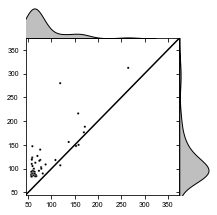

<Figure size 432x288 with 0 Axes>

In [69]:
plt.figure(figsize=(2,2))
plt.rcParams['font.size'] = 7
kwargs = {'wl_lb':100, 'wl_ub':1000,}
pred_df = predictions_dict['b3lyp']["pred_df"]
pred_df

x_vals = np.array(pred_df.loc[:, kwargs['wl_lb']+1:kwargs['wl_ub']].columns)
print(x_vals.shape)
distance_function  = lambda x,y : stats.wasserstein_distance (x_vals, x_vals, x,y)

pred_df = predictions_dict['b3lyp']["pred_df"]
pred_df
pred_scores = list(get_uniqueness(pred_df, distance_function, parse_spectra_peaks=False, topk_frac=1, **kwargs,
                                 intensity_thresh=0) )
pred_scores[0] = pred_scores[0][np.flip(np.argsort(pred_scores[1]))]
pred_scores[1] = np.flip(np.sort(pred_scores[1]))
mol_codes = [m.split('_')[0] for m in pred_scores[0]]
exp_scores = get_uniqueness(exp_spec_df.loc[mol_codes,pred_df.columns], distance_function, parse_spectra_peaks=False, 
                            topk_frac = 1, intensity_thresh=0, **kwargs)

ssr = sum([(y-x)**2 for x,y in zip(exp_scores[1], pred_scores[1])])
sst = sum([(y-np.mean(pred_scores[1]))**2 for y in exp_scores[1]])
print (ssr,sst, 1-ssr/sst)

print (stats.pearsonr(exp_scores[1], pred_scores[1]).statistic**2)

sns.jointplot(x=exp_scores[1], y=pred_scores[1], 
              s = 5, space=0, 
              color='black', height=3,#ratio=0.3, 
              hue=['black']*len(pred_scores[1]),palette=['black'], legend=False)
all_scores = np.concatenate([exp_scores[1],pred_scores[1]])
lims = (np.nanmin(all_scores)*0.8, np.nanmax(all_scores)*1.2)
plt.plot(lims,lims, color='black')

plt.xlim(*lims)
plt.ylim(*lims)
plt.show()
plt.savefig('../../../../Manuscripts/HSI_manuscript/figure_imgs/{}_benchmark_b3lyp_wasserstein_photochemdb.pdf'.format(date_str))

(899,)
Filtering spectrum dataframe
Original dataframe dimensions: (50, 932)
After filtering: (50, 899)
scoring whole spectra
Comparing to 50 molecules
Filtering spectrum dataframe
Original dataframe dimensions: (50, 932)
After filtering: (50, 899)
scoring whole spectra
Comparing to 50 molecules
22478.56131584497 90739.95512277131 0.7522749346147302
0.7742418017802406


<Figure size 144x144 with 0 Axes>

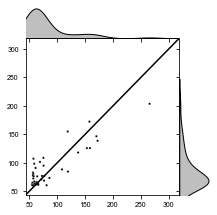

In [76]:
plt.figure(figsize=(2,2))
plt.rcParams['font.size'] = 7
kwargs = {'wl_lb':100, 'wl_ub':1000,}
pred_df = predictions_dict['wb97xd']["pred_df"]
pred_df

x_vals = np.array(pred_df.loc[:, kwargs['wl_lb']+1:kwargs['wl_ub']].columns)
print(x_vals.shape)
distance_function  = lambda x,y : stats.wasserstein_distance (x_vals, x_vals, x,y)

pred_df = predictions_dict['wb97xd']["pred_df"]
pred_df
pred_scores = list(get_uniqueness(pred_df, distance_function, parse_spectra_peaks=False, topk_frac=1, **kwargs,
                                 intensity_thresh=0) )
pred_scores[0] = pred_scores[0][np.flip(np.argsort(pred_scores[1]))]
pred_scores[1] = np.flip(np.sort(pred_scores[1]))
mol_codes = [m.split('_')[0] for m in pred_scores[0]]
exp_scores = get_uniqueness(exp_spec_df.loc[mol_codes,pred_df.columns], distance_function, parse_spectra_peaks=False, 
                            topk_frac = 1, intensity_thresh=0, **kwargs)

ssr = sum([(y-x)**2 for x,y in zip(exp_scores[1], pred_scores[1])])
sst = sum([(y-np.mean(pred_scores[1]))**2 for y in exp_scores[1]])
print (ssr,sst, 1-ssr/sst)

print (stats.pearsonr(exp_scores[1], pred_scores[1]).statistic**2)

sns.jointplot(x=exp_scores[1], y=pred_scores[1], 
              s = 5, space=0, 
              color='black', height=3,#ratio=0.3, 
              hue=['black']*len(pred_scores[1]),palette=['black'], legend=False)
all_scores = np.concatenate([exp_scores[1],pred_scores[1]])
lims = (np.nanmin(all_scores)*0.8, np.nanmax(all_scores)*1.2)
plt.plot(lims,lims, color='black')

plt.xlim(*lims)
plt.ylim(*lims)
plt.show()


(1176,)
(1176,)
5285832.153430634 8126893.161266243 0.34958759164897724


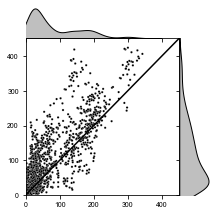

In [75]:
from scipy.spatial import distance
x_vals = np.array(pred_df.columns)
distance_function  = lambda x,y : stats.wasserstein_distance (x_vals, x_vals, x,y)

all_pred_wass = distance.pdist(pred_df.values[1:,:], metric=distance_function)
mol_codes_for_all_preds = [x.split('_')[0] for x in pred_df.index]
all_exp_wass = distance.pdist(exp_spec_df.loc[mol_codes_for_all_preds,pred_df.columns].values[1:,:], metric=distance_function)

print (all_pred_wass.shape)
print (all_exp_wass.shape)

ssr = sum([(y-x)**2 for x,y in zip(all_exp_wass, all_pred_wass)])
sst = sum([(y-np.mean(all_pred_wass))**2 for y in all_exp_wass])
print (ssr,sst, 1-ssr/sst)

sns.jointplot(x=all_exp_wass, y=all_pred_wass, 
              s = 5, space=0, 
              color='black', height=3,#ratio=0.3, 
              hue=['black']*len(all_exp_wass),palette=['black'], legend=False)

lims = [0,np.max([all_pred_wass, all_exp_wass])]
plt.xlim(*lims)
plt.ylim(*lims)
plt.plot(lims,lims, color='black')
plt.show()

In [70]:
import plotly.express as px
px.scatter(x=exp_scores[1], y=pred_scores[1], hover_name=exp_scores[0])

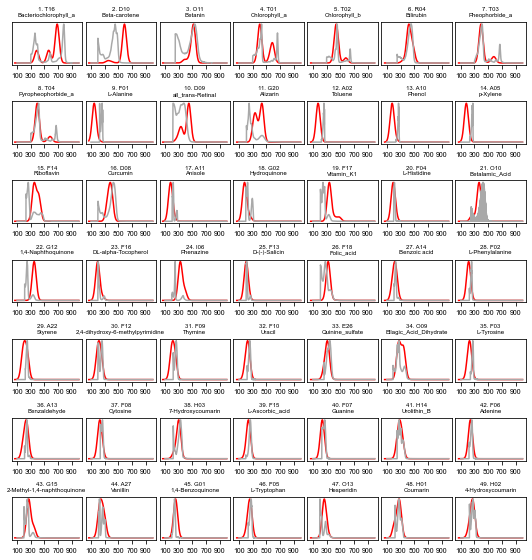

In [71]:
num_columns = 7
num_rows = int(np.ceil(len(mol_codes) / num_columns))

cmap = plt.get_cmap('tab10')
f, ax = plt.subplots(num_rows, num_columns, figsize=(7.4, 7.8))

for i, c in enumerate(mol_codes):
    row = i // num_columns
    col = i % num_columns

    try:
        
#         pred_spec = 
        
        ax[row, col].plot(predictions_dict['b3lyp']['pred_df'].columns, (predictions_dict['b3lyp']['pred_df'].loc['{}_b3lyp'.format(c), :]
                           / predictions_dict['b3lyp']['pred_df'].loc['{}_b3lyp'.format(c), :].max()),
                          color='red')
    except:
        pass
    
    ax[row, col].plot(exp_spec_df.columns[100:1001], 
                      (exp_spec_df.loc[c, 100:1000] / np.max(exp_spec_df.loc[c, 100:1000])), color='darkgray')
    ax[row, col].set_yticks([])
    ax[row, col].set_xticks([100, 300, 500, 700, 900])
    
    ax[row, col].set_title('{}. {}\n{}'.format(i + 1, c, code_to_name[c]), fontsize=6, rotation=0)
    ax[row, col].yaxis.set_label_coords(-0.4, 0.3)

# Hide empty subplots if any
for i in range(len(mol_codes), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    ax[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05) 
plt.savefig('../../../../Manuscripts/HSI_manuscript/figure_imgs/{}_overlapped_comparison_b3lyp_wasserstein_photochemdb_S1.pdf'.format(date_str))
plt.show()

In [37]:
pred_scores
pred_score_df = pd.DataFrame({'code':[c.split('_')[0] for c in pred_scores[0]], 'pred_score':pred_scores[1]})
exp_score_df = pd.DataFrame({'code':exp_scores[0], 'exp_score':exp_scores[1]})

joint_score_df = pred_score_df.merge(exp_score_df, on='code', how='inner')
joint_score_df.index = joint_score_df['code'].map(lambda x : code_to_name[x])

In [10]:
# joint_score_df.to_csv('../../../Manuscripts/HSI_manuscript/figure_imgs/{}_benchmarking_score_comparison_B3LYP_tableS2.csv'.format(date_str))

In [11]:
all_scores

array([264.74854917, 118.59005165, 157.28640454, 171.73650014,
       169.61680577, 137.05282452,  58.93002052, 158.15646397,
       152.65642563,  75.69621622,  69.73981571,  58.62008656,
        58.06800045,  57.73602018,  75.90743144, 108.43836742,
        74.00688896,  65.27087616,  57.68513088,  87.37097463,
       118.89667324,  59.17824881,  77.68413751,  62.1863978 ,
        78.08641617,  59.52490716,  73.03118021,  59.39286144,
        61.7447558 ,  63.91516126,  56.65739945,  57.77936273,
        81.30874089,  60.30945405,  58.14511041,  64.30219863,
        56.83587835,  66.44667296,  56.34839075,  56.09300377,
        64.8578887 ,  57.98678485,  60.4489376 ,  58.11507248,
        67.51983541,  57.09862029,  64.92719057,  57.64809609,
        57.12671145, 312.21731966, 280.0798453 , 216.28079522,
       188.22954052, 176.61052706, 156.24578569, 150.66577501,
       150.1532429 , 147.77267119, 140.15766744, 126.8243649 ,
       123.85777598, 120.85849703, 119.19922362, 118.46

In [39]:
# pd.DataFrame({'code':exp_scores[0],'name':[code_to_name[x] for x in exp_scores[0]], 'Experimental':exp_scores[1], 'Predicted':pred_scores[1]}).to_csv('../../../../Manuscripts/HSI_manuscript/figure_imgs/14May2024_photochemcad_benchmarking_summary_SuppTableS1.csv', index=False)

In [45]:
predictions_dict['b3lyp']['pred_df'].index[predictions_dict['b3lyp']['pred_df'].max(axis=1)*30<0.1]

Index(['A01_b3lyp', 'F13_b3lyp', 'F17_b3lyp', 'G12_b3lyp'], dtype='object')

In [53]:
(predictions_dict['b3lyp']['pred_df'].max(axis=1)*30)[predictions_dict['b3lyp']['pred_df'].max(axis=1)*30<0.1]

A01_b3lyp    0.000000
F13_b3lyp    0.079888
F17_b3lyp    0.083872
G12_b3lyp    0.079852
dtype: float64

<AxesSubplot: >

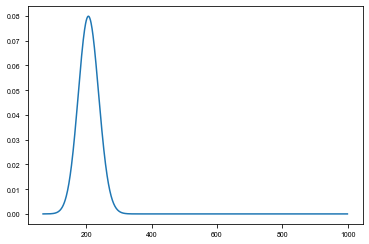

In [57]:
(30*predictions_dict['b3lyp']['pred_df'].loc['F13_b3lyp']).plot()